### DATA 558 - Homework 1 Coding Solutions
#### Anushna Prakash
#### April 8th, 2021

In [1]:
import pandas as pd
import numpy as np

In [2]:
file = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'
penguins = pd.read_csv(file, sep = ',', header = 0)
penguins.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

Reduce dataset to rows where desired feature columns are not null

In [3]:
# Clean up missing values. Removes 2 rows of data
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print(penguins[features].isnull().sum(axis = 0))
penguins_clean = penguins[features].dropna()
penguins_clean.shape

bill_length_mm       2
bill_depth_mm        2
flipper_length_mm    2
body_mass_g          2
dtype: int64


(342, 4)

In [4]:
X = penguins_clean[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = penguins_clean['body_mass_g']
print(X.shape)
print(y.shape)

(342, 3)
(342,)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [6]:
from sklearn.linear_model import Ridge
penguin_ridge = Ridge(alpha = 1)
penguin_ridge.fit(X_train, y_train)

Ridge(alpha=1)

Compute Mean Squared Error for ridge regression predictions.
\begin{equation}
MSE(\hat{Y}, Y) = \frac{1}{n} {||\hat{Y} - Y||}^{2}_{2}
\end{equation}

In [7]:
def calc_mse(y_hat, y):
    n = len(y_hat)
    errors = np.square(y_hat - y).sum()
    return(errors / n)

In [8]:
y_hat = penguin_ridge.predict(X_train)
calc_mse(y_hat, y_train.to_numpy())

154610.82032308922

Perform 5x2 validation to determine optimal $\lambda$ value.

In [32]:
def fivebytwo_validation_ridge(train_data, train_targets, lambda_vals):
    """
        For each value of your hyperparameter, repeat the following procedure five times:
        Shuffle the indices of the training data.
        Split the training data evenly into two parts. Call these the "train" and "validation" sets.
        Train the model using data from the "train" set.
        Generate model predictions for the "validation" set and record the prediction accuracy.
        Swap the role of the "train" and "validation" sets and repeat the training and prediction steps above.
        Select the hyperparameter value with the best average prediction accuracy over all 10 trials.
    """
    n = len(train_targets)
    results = np.zeros((10, len(lambda_vals)))
    
    for j, k in enumerate(lambda_vals):
        
        for i in range(5):
            # Shuffle the indices of training data
            shuffle_i = np.random.choice(n, size = n, replace = False)
            shuffled_data = train_data.iloc[shuffle_i, ]
            shuffled_targets = train_targets[shuffle_i]
            
            # Split training data evenly into two parts: train and validation sets
            split = int(np.floor(n / 2))
            train = shuffled_data.iloc[split:, ]
            validate = shuffled_data.iloc[:split, ]
            train_tgts = shuffled_targets[split:]
            validate_tgts = shuffled_targets[:split]
            
            # Train model using training set and generate predictions
            ridge = Ridge(alpha = k).fit(train, train_tgts)
            predictions = ridge.predict(validate)
            
            # Save MSE
            results[2 * i, j] = calc_mse(predictions, validate_tgts)
            
            # Swap train and validation sets, and save MSE
            ridge_swap = Ridge(alpha = k).fit(validate, validate_tgts)
            predictions_swap = ridge_swap.predict(train)
            results[(2 * i) + 1, j] = calc_mse(predictions_swap, train_tgts)
    
    return(results)

In [33]:
lam_vals = np.logspace(-2, 4, 19)
mse_results = fivebytwo_validation_ridge(X_train, y_train.to_numpy(), lam_vals)
mse_results

array([[150399.54247645, 159492.38805068, 163105.07164885,
        187729.84101301, 178828.82340856, 168728.30963847,
        138443.80387112, 169642.91629454, 167967.08203143,
        143268.15457986, 166371.58164315, 137157.48983478,
        161861.54100964, 175454.45000245, 179991.2601779 ,
        144035.71252704, 156279.08767117, 155500.87896037,
        163672.58869182],
       [160347.45889423, 153491.73749469, 153268.20093302,
        135576.64257821, 132284.77696181, 154842.46081399,
        180275.00720786, 166259.17124154, 155775.44847898,
        180793.73755898, 152948.61110549, 175752.70920204,
        179544.42484728, 138399.62186489, 147679.30164379,
        177157.69476145, 159396.27407118, 174472.33550835,
        234855.64110348],
       [165004.41900958, 164595.3171095 , 170382.33997116,
        158887.7790317 , 162861.24159781, 153059.82547829,
        162458.25555607, 148155.18130954, 159917.43541378,
        154295.4457177 , 178721.27822562, 177803.42645534,
    

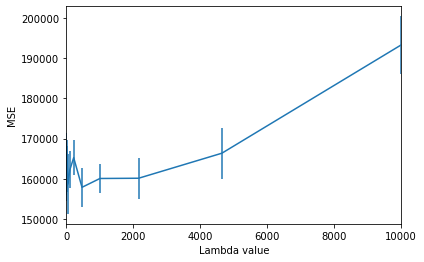

In [54]:
import matplotlib.pyplot as plt
# plot results
plt.errorbar(lam_vals, mse_results.mean(axis = 0), mse_results.std(axis = 0) / np.sqrt(mse_results.shape[0]))
plt.xlim([lam_vals[0] - 0.5, lam_vals[-1] + 0.5])
plt.xlabel('Lambda value')
plt.ylabel('MSE')
plt.show()

In [77]:
results = pd.DataFrame(mse_results.mean(axis = 0), lam_vals, columns = ['MSE'])
results.sort_values(by = 'MSE', axis = 0, ascending = True)

,MSE
0.464159,157727.272456
464.158883,157857.909296
46.415888,158672.826941
1.000000,159321.022413
0.046416,159322.793976
1000.000000,160053.964416
2154.434690,160112.787892
4.641589,161155.136687
0.010000,161587.160373
2.154435,161912.388140


,MSE
0.464159,157727.272456
